In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as Fn
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt



In [2]:
import data_loader
trainDataLoader, testDataLoader = data_loader.getDatapoints()


0 data points are processed
1000 data points are processed
2000 data points are processed
3000 data points are processed
4000 data points are processed
5000 data points are processed
6000 data points are processed
7000 data points are processed
8000 data points are processed
9000 data points are processed
10000 data points are processed
11000 data points are processed
Completed collecting all the data points X: (11970, 46) and Y: (11970,)
Train Data Size: 10773 and Test Data Size: 1197


In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 128)  
        self.fc2 = nn.Linear(128, 64)   
        self.fc3 = nn.Linear(64, 32) 
        self.fc4 = nn.Linear(32, num_classes)  
        
        self.relu = nn.ReLU()

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        lstm_out = h_n[-1]
        x = Fn.relu(self.fc1(lstm_out))
        x = Fn.dropout(x, 0.35)
        x = Fn.relu(self.fc2(x))
        x = Fn.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

input_size = 10  # Number of features (e.g., input size per timestep)
hidden_size = 128  # Number of hidden units in LSTM
num_classes = 6  # Number of output classes

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

# Print model architecture
print(model)


LSTMModel(
  (lstm): LSTM(10, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=6, bias=True)
  (relu): ReLU()
)


In [4]:
model = LSTMModel(input_size=46, hidden_size=256, num_classes=6)
device = torch.device("cpu")
print(f"Model SUmmary: {model}")
lossFn = nn.CrossEntropyLoss()
reg = torch.optim.Adam(params=model.parameters(), lr=0.00001)
model.to(device)

for param in model.parameters():
    param.requires_grad = True 
    # lossFn = nn.CrossEntropyLoss()
    # print(param.requires_grad)
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []


epochs = 50
for num_epoch in range(epochs):
    model.train(True)
    epoch_loss = 0
    correct_pred = 0
    total_samples = 0
    for index, (trainX, trainY) in enumerate(trainDataLoader):
        trainX = trainX.unsqueeze(1)
        trainY = trainY.float()
        trainX = trainX.to(device)
        trainY = trainY.to(device)
        # print(trainX.)
        # print(trainX.shape)
        out = model(trainX)
        # print(out.shape)
        
        # pred = torch.argmax(out, dim=1)
        # print(trainY)
        trainY = trainY.long()
        # pred = pred.long()

        # print(trainX.shape, trainY.shape)

        lossValue = lossFn(out, trainY)
        # lossValue.requires_grad = True
        reg.zero_grad()
        # lossValue.requires_grad = True


        lossValue.backward()
        reg.step()

        epoch_loss += lossValue.item()

        # break
        with torch.no_grad(): 
            predictions = torch.argmax(out, dim=1)  
            correct_pred += (predictions == trainY).sum().item()  
            total_samples += trainY.size(0)  
    
    average_loss = epoch_loss / len(trainDataLoader) 
    accuracy = correct_pred / total_samples * 100  
    train_accuracies.append(accuracy)
    train_losses.append(average_loss)
     # Display metrics for the epoch
    print(f"Epoch {num_epoch + 1}/{epochs}, Training Loss: {average_loss:.4f}, Training Accuracy: {accuracy:.4f}%")


    model.eval()  # Switch to evaluation mode
    with torch.no_grad():  # Disable gradients for test set
        correct_pred_test = 0
        total_samples_test = 0
        test_loss = 0
        for testX, testY in testDataLoader:
            testX = testX.unsqueeze(1)
            testY = testY.to(device)

            # Forward pass for test data
            test_out = model(testX)
            test_loss_value = lossFn(test_out, testY.long())
            test_loss += test_loss_value.item()
            
            testY = testY.long()
            predictions_test = torch.argmax(test_out, dim=1)  
            correct_pred_test += (predictions_test == testY).sum().item()  
            total_samples_test += testY.size(0)

        average_test_loss = test_loss / len(testDataLoader) 
        test_accuracy = correct_pred_test / total_samples_test * 100  
        test_accuracies.append(test_accuracy)
        test_losses.append(average_test_loss)

        print(f"    Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%")




    if(accuracy >= 99):
        print(f"Stopping the Training as Accuracy has reached to Maximum")
        break

print(f"Training Completed for  this {len(train_accuracies)} epochs")
torch.save(model.state_dict(), f = "/Users/ishananand/Desktop/ser/Speech-Emotion-Recognition/model_weight/LSTM_model1.pth")
    

Model SUmmary: LSTMModel(
  (lstm): LSTM(46, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=6, bias=True)
  (relu): ReLU()
)
Epoch 1/50, Training Loss: 1.7889, Training Accuracy: 16.4949%
    Test Loss: 1.7857, Test Accuracy: 16.5414%
Epoch 2/50, Training Loss: 1.7801, Training Accuracy: 16.4949%
    Test Loss: 1.7752, Test Accuracy: 16.5414%
Epoch 3/50, Training Loss: 1.7678, Training Accuracy: 16.4949%
    Test Loss: 1.7607, Test Accuracy: 16.5414%
Epoch 4/50, Training Loss: 1.7520, Training Accuracy: 16.4949%
    Test Loss: 1.7423, Test Accuracy: 16.5414%
Epoch 5/50, Training Loss: 1.7281, Training Accuracy: 17.0983%
    Test Loss: 1.7120, Test Accuracy: 19.6324%
Epoch 6/50, Training Loss: 1.6933, Training Accuracy: 23.1876%
    Test Loss: 1.6697, Test Accuracy: 29.8246%
Epoch 7/50,

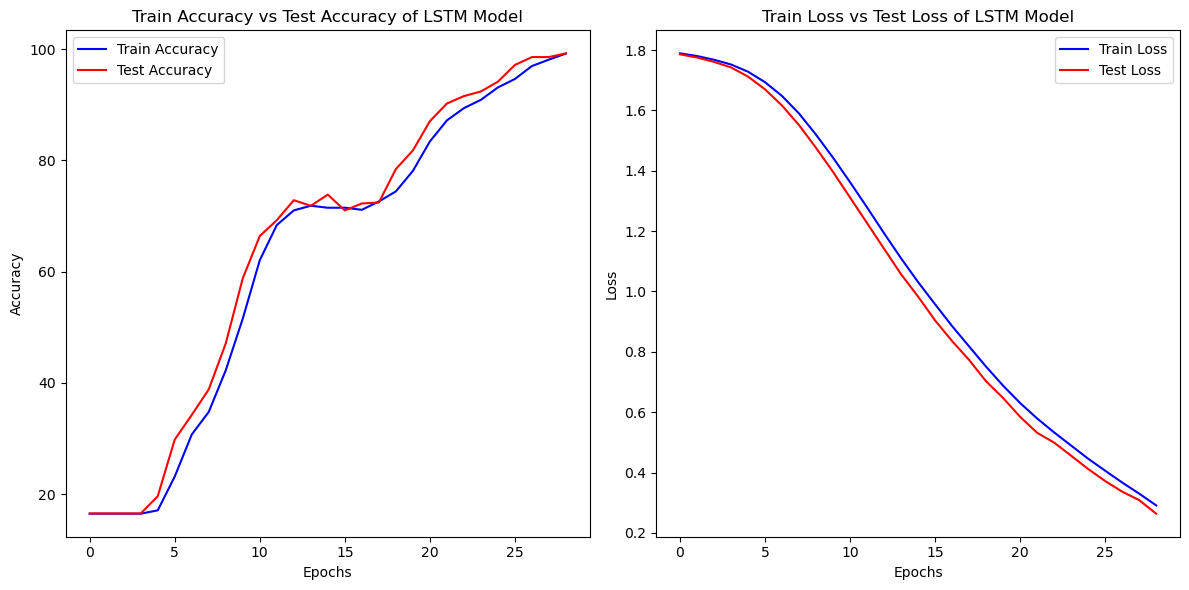

In [5]:
# Plotting Train Accuracy and Test Accuracy
plt.figure(figsize=(12, 6))  # Set figure size
plt.subplot(1, 2, 1)  # Create subplot for accuracy graph
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Test Accuracy of LSTM Model')
plt.legend()

# Plotting Train Loss and Test Loss
plt.subplot(1, 2, 2)  # Create subplot for loss graph
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss of LSTM Model')
plt.legend()

# Show the plots
plt.tight_layout()  
plt.show()


In [ ]:
def testnewAudio(modelPath, testAudioPath):

    test_model = LSTMModel(input_size=46, hidden_size=256, num_classes=6)

    # Load the saved model weights
    test_model.load_state_dict(torch.load(modelPath))
    test_model.eval()

    allAudios = os.listdir(testAudioPath)
    emotion_class = {
        0: "happy",
        1: "angry",
        2: "fear",
        3: "sad",
        4: "disgust",
        5: "neutral"
    }
    X, Y = [], []
    for each_audio in allAudios:
        # print(testAudioPath + "/" +each_audio)

        # test_audio = getMelVector(rootpath + "/" +each_audio, 4)
        test_audio = data_loader.extract_speech_features(audio_path=testAudioPath + "/" + each_audio)
        # print(test_audio)
        
        X.append(test_audio)
        if("happy" in each_audio):
            # print(f" Audio {each_audio} and 0")
            Y.append(0)
        elif("angry" in each_audio):
            # print(f" Audio {each_audio} and 1")
            Y.append(1)
        elif("fear" in each_audio):
            # print(f" Audio {each_audio} and 2")
            Y.append(2)
        elif("sad" in each_audio):
            # print(f" Audio {each_audio} and 3")
            Y.append(3)
        elif("disgust" in each_audio):
            # print(f" Audio {each_audio} and 4")
            Y.append(4)
        elif("neutral" in each_audio):
            # print(f" Audio {each_audio} and 5")
            Y.append(5)
        
        

    X = np.array(X)
    Y = np.array(Y)
    Y = Y.astype(np.int64)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    Y_tensor = torch.tensor(Y, dtype=torch.long)  

    dataset = TensorDataset(X_tensor, Y_tensor)
    customLoader = DataLoader(dataset, batch_size=1, shuffle=False)
    # customLoader.dataset
    with torch.no_grad():
        for x, y in customLoader:

            x = x.unsqueeze(1)  # Adds a channel dimension at position 1
            x = x.to(device)
            y = y.to(device)
            # print(x.shape)
            scores = test_model(x)
            
            
            predictions = torch.argmax(scores, dim=1)
            # print(scores, predictions, y)
            print(f" Actual Emotion: {emotion_class[y.item()]} and Predicted Emotion is of: {emotion_class[int(predictions.item())]}")
            # tensor_int = int(predictions.to(torch.int32))
            # print(customLoader.)
            # print(predictions, "-----", y)
            # print(f" The true Value is {emotion_class[y]} and predicted class is {emotion_class[tensor_int]}")
            # print(scores)

            
            # print(predictions)

        test_model.train()
newAudiosPath = "/Users/ishananand/Desktop/ser/testAudios"
model_path = "/Users/ishananand/Desktop/ser/Speech-Emotion-Recognition/model_weight/LSTM_model1.pth"
testnewAudio(model_path, newAudiosPath)


Actual Emotion: angry and Predicted Emotion is of: angry
Actual Emotion: angry and Predicted Emotion is of: fear
Actual Emotion: angry and Predicted Emotion is of: angry
Actual Emotion: disgust and Predicted Emotion is of: happy
Actual Emotion: fear and Predicted Emotion is of: fear
Actual Emotion: fear and Predicted Emotion is of: happy
Actual Emotion: disgust and Predicted Emotion is of: disgust
Actual Emotion: disgust and Predicted Emotion is of: sad
Actual Emotion: fear and Predicted Emotion is of: fear
Actual Emotion: sad and Predicted Emotion is of: sad
Actual Emotion: sad and Predicted Emotion is of: disgust
Actual Emotion: sad and Predicted Emotion is of: sad
Actual Emotion: happy and Predicted Emotion is of: neutral
Actual Emotion: neutral and Predicted Emotion is of: neutral
Actual Emotion: neutral and Predicted Emotion is of: sad
Actual Emotion: happy and Predicted Emotion is of: happy
Actual Emotion: happy and Predicted Emotion is of: angry
Actual Emotion: neutral and Predi